In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import geopy.distance
import tqdm
import seaborn

To build the dataset run from here...

In [314]:
# core dataset 
data = pd.read_csv('s3://ecb-hackathon-data-group02-x19s00/economic_data/dataset_nuts3_2002-2018.csv' )

data=data.pivot(index=['year','geo','sector'],columns='variable',values=['value']).droplevel(0,axis=1).reset_index()
data =data.rename(columns={'gross value added':'GVA'})
#data = data[data.sector=='A']

#data['norm_GVA']= data['GVA']/data['employment']
#data['national_GVA']=data.groupby([data.geo.str[:2],'year']).norm_GVA.transform('mean')
data = data.sort_values(['geo','year'])
#data['diff_national_GVA']=data.groupby('geo').national_GVA.transform('diff')/data.national_GVA
#data['diff_GVA']=data.groupby('geo').norm_GVA.transform('diff')/data.norm_GVA
#data['local_ppt_dev_GVA'] = data['diff_GVA'] -data['diff_national_GVA'] 

data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [315]:
### add climate extreme
### SMA DATA
import s3fs
fs = s3fs.S3FileSystem(anon=False)
files_sma=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/soil_mosture_anomaly/')]


for i, f in enumerate(files_sma):
    if i ==0:
        sma = pd.read_csv('s3://'+f)
    else:
        sma = pd.concat([sma,pd.read_csv('s3://'+f)])

#sma = sma.drop(['NUTS_CODE', 'TIMESTAMP', 'MEDIAN'],axis=1)
sma.columns=['geo', 'TIMESTAMP', 'MIN_SMA']

sma= sma.dropna(how='all')

sma['TIMESTAMP']= pd.to_datetime(sma.TIMESTAMP)

sma['year'] = sma.TIMESTAMP.dt.year 

sma=sma.groupby(['geo','year']).min().reset_index().drop('TIMESTAMP',axis=1)

data = data.merge(sma,left_on=['geo','year'],right_on=['geo','year'],how='left')

# TMAX
files_tmax=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/temp_max/')]
for i, f in enumerate(files_tmax[1:]):
    if i ==0:
        tmax = pd.read_csv('s3://'+f)
    else:
        tmax = pd.concat([tmax,pd.read_csv('s3://'+f)])

tmax.columns=['geo', 'TIMESTAMP', 'MAX_TMAX']

tmax= tmax.dropna(how='all')

tmax['TIMESTAMP']= pd.to_datetime(tmax.TIMESTAMP)

tmax['year'] = tmax.TIMESTAMP.dt.year 

tmax=tmax.groupby(['geo','year']).max().reset_index().drop('TIMESTAMP',axis=1)

data = data.merge(tmax,left_on=['geo','year'],right_on=['geo','year'],how='left')

# SPI
files_spa01=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/spi/') if
             f.find('spa12')!=-1]
for i, f in enumerate(files_spa01):
    if i ==0:
        spi = pd.read_csv('s3://'+f)
    else:
        spi = pd.concat([spi,pd.read_csv('s3://'+f)])
spi = spi.iloc[:,:3]
spi.columns=['geo', 'TIMESTAMP', 'MIN_SPI']

spi= spi.dropna(how='all')

spi['TIMESTAMP']= pd.to_datetime(spi.TIMESTAMP)

spi['year'] = spi.TIMESTAMP.dt.year 

spi=spi.groupby(['geo','year']).min().reset_index().drop('TIMESTAMP',axis=1)

data = data.merge(spi,left_on=['geo','year'],right_on=['geo','year'],how='left')

# LOW FLOW INDEX
files_lfi=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/low_flow_index/')]
for i, f in enumerate(files_lfi):
    if i ==0:
        lfi = pd.read_csv('s3://'+f)
    else:
        lfi = pd.concat([lfi,pd.read_csv('s3://'+f)])
lfi = lfi.iloc[:,:3]
lfi.columns=['geo', 'TIMESTAMP', 'MAX_LFI']

lfi= lfi.dropna(how='all')

lfi['TIMESTAMP']= pd.to_datetime(lfi.TIMESTAMP)

lfi['year'] = lfi.TIMESTAMP.dt.year 

lfi=lfi.groupby(['geo','year']).max().reset_index().drop('TIMESTAMP',axis=1)

data = data.merge(lfi,left_on=['geo','year'],right_on=['geo','year'],how='left')

#absorbed_photosynthetically_active_radiation_anomaly
files_apar=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/absorbed_photosynthetically_active_radiation_anomaly/')]
for i, f in enumerate(files_apar):
    if i ==0:
        apar = pd.read_csv('s3://'+f)
    else:
        apar = pd.concat([apar,pd.read_csv('s3://'+f)])
apar = apar.iloc[:,:3]
apar.columns=['geo', 'TIMESTAMP', 'MIN_APAR']

apar= apar.dropna(how='all')

apar['TIMESTAMP']= pd.to_datetime(apar.TIMESTAMP)

apar['year'] = apar.TIMESTAMP.dt.year 

apar=apar.groupby(['geo','year']).min().reset_index().drop('TIMESTAMP',axis=1)

data = data.merge(apar,left_on=['geo','year'],right_on=['geo','year'],how='left')

#heat wave

hi = pd.read_csv('s3://ecb-hackathon-data-group02-x19s00/climate_data/heat_intensity/intensity_2001-2022.csv')

hi.columns = ['date','year','geo','MAX_HI']
hi=hi.drop('date',axis=1).groupby(['geo','year']).max().reset_index()

data = data.merge(hi,left_on=['geo','year'],right_on=['geo','year'],how='left')

In [152]:
### turn to aggregates
print('process APAR')
files_apar=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/absorbed_photosynthetically_active_radiation_anomaly/')]
for i, f in enumerate(files_apar):
    if i ==0:
        apar = pd.read_csv('s3://'+f)
    else:
        apar = pd.concat([apar,pd.read_csv('s3://'+f)])
apar = apar.iloc[:,:3]
apar.columns=['geo', 'TIMESTAMP', 'APAR']
apar= apar.dropna(how='all')
apar['TIMESTAMP']= pd.to_datetime(apar.TIMESTAMP)
apar['year'] = apar.TIMESTAMP.dt.year 
apar['ROLLING']=apar.groupby('geo')['APAR'].transform(lambda x: x.rolling(3, 1).mean())
apar['MONTH']=apar.TIMESTAMP.dt.month
apar=apar[apar.MONTH.isin([3,6,9,12])].pivot(index=['geo','year'],columns='MONTH',values='ROLLING').reset_index()
apar = apar.rename({9:'APAR_SUMMER',3:'APAR_WINTER',12:'APAR_FALL',6:'APAR_SPRING'},axis=1)

### SMA DATA
print('process SMA')

files_sma=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/soil_mosture_anomaly/')]
for i, f in enumerate(files_sma):
    if i ==0:
        sma = pd.read_csv('s3://'+f)
    else:
        sma = pd.concat([sma,pd.read_csv('s3://'+f)])
sma.columns=['geo', 'TIMESTAMP', 'SMA']
sma= sma.dropna(how='all')
sma['TIMESTAMP']= pd.to_datetime(sma.TIMESTAMP)
sma['year'] = sma.TIMESTAMP.dt.year 
sma['ROLLING']=sma.groupby('geo')['SMA'].transform(lambda x: x.rolling(3, 1).mean())
sma['MONTH']=sma.TIMESTAMP.dt.month
sma=sma[sma.MONTH.isin([3,9,6,12])].pivot(index=['geo','year'],columns='MONTH',values='ROLLING').reset_index()
sma = sma.rename({9:'SMA_SUMMER',3:'SMA_WINTER',6:'SMA_SPRING',12:'SMA_FALL'},axis=1)

# TMAX
print('process TMAX')

files_tmax=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/temp_max/')]
for i, f in enumerate(files_tmax[1:]):
    if i ==0:
        tmax = pd.read_csv('s3://'+f)
    else:
        tmax = pd.concat([tmax,pd.read_csv('s3://'+f)])
tmax.columns=['geo', 'TIMESTAMP', 'TMAX']
tmax= tmax.dropna(how='all')
tmax['TIMESTAMP']= pd.to_datetime(tmax.TIMESTAMP)
tmax['year'] = tmax.TIMESTAMP.dt.year 
tmax['ROLLING']=tmax.groupby('geo')['TMAX'].transform(lambda x: x.rolling(3, 1).mean())
tmax['MONTH']=tmax.TIMESTAMP.dt.month
tmax=tmax[tmax.MONTH.isin([3,9,6,12])].pivot(index=['geo','year'],columns='MONTH',values='ROLLING').reset_index()
tmax= tmax.rename({9:'TMAX_SUMMER',3:'TMAX_WINTER',6:'TMAX_SPRING',12:'TMAX_FALL'},axis=1)

# SPI
print('process SPI')

files_spa01=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/spi/') if
             f.find('spa12')!=-1]
for i, f in enumerate(files_spa01):
    if i ==0:
        spi = pd.read_csv('s3://'+f)
    else:
        spi = pd.concat([spi,pd.read_csv('s3://'+f)])
spi = spi.iloc[:,:3]
spi.columns=['geo', 'TIMESTAMP', 'SPI']
spi= spi.dropna(how='all')
spi['TIMESTAMP']= pd.to_datetime(spi.TIMESTAMP)
spi['year'] = spi.TIMESTAMP.dt.year 
spi['ROLLING']=spi.groupby('geo')['SPI'].transform(lambda x: x.rolling(3, 1).mean())
spi['MONTH']=spi.TIMESTAMP.dt.month
spi=spi[spi.MONTH.isin([3,9,6,12])].pivot(index=['geo','year'],columns='MONTH',values='ROLLING').reset_index()
spi=spi.rename({9:'SPI_SUMMER',3:'SPI_WINTER',12:'SPI_FALL',6:'SPI_SPRING'},axis=1)

# LOW FLOW INDEX
print('process LFI')

files_lfi=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/low_flow_index/')]
for i, f in enumerate(files_lfi):
    if i ==0:
        lfi = pd.read_csv('s3://'+f)
    else:
        lfi = pd.concat([lfi,pd.read_csv('s3://'+f)])
lfi = lfi.iloc[:,:3]
lfi.columns=['geo', 'TIMESTAMP', 'LFI']
lfi= lfi.dropna(how='all')
lfi['TIMESTAMP']= pd.to_datetime(lfi.TIMESTAMP)
lfi['year'] = lfi.TIMESTAMP.dt.year 
lfi['ROLLING']=lfi.groupby('geo')['LFI'].transform(lambda x: x.rolling(3, 1).mean())
lfi['MONTH']=lfi.TIMESTAMP.dt.month
lfi=lfi[lfi.MONTH.isin([3,9,6,12])].pivot(index=['geo','year'],columns='MONTH',values='ROLLING').reset_index()
lfi = lfi.rename({9:'LFI_SUMMER',3:'LFI_WINTER',6:'LFI_SPRING',12:'LFI_FALL'},axis=1)

#heat wave -- is it necessary??

data = data.merge(lfi,left_on=['geo','year'],right_on=['geo','year'],how='left')
data = data.merge(apar,left_on=['geo','year'],right_on=['geo','year'],how='left')
data = data.merge(sma,left_on=['geo','year'],right_on=['geo','year'],how='left')
data = data.merge(spi,left_on=['geo','year'],right_on=['geo','year'],how='left')
data = data.merge(tmax,left_on=['geo','year'],right_on=['geo','year'],how='left')

process APAR
process SMA
process TMAX
process SPI
process LFI


In [14]:
# spatial aggregates
geospatial_info = pd.read_csv('s3://ecb-hackathon-data-group02-x19s00/our_data/nuts3_enriched.csv',sep=';')

list_results = []
list_geo = []
list_year = []
for i, row in tqdm.tqdm(data[['year','geo']].drop_duplicates().iterrows()):
    nuts = row.geo
    year = row.year
    list_geo.append(nuts)
    list_year.append(year)
    list_nearby = geospatial_info[geospatial_info.NUTS_ID == nuts].NEAR_NUTS
    if len(list_nearby.to_list())==0:
        list_results.append(data[(data.year==year)&(data.geo==nuts)].iloc[:,14:19].fillna(0).mean())
        continue

    exec('lista_nearby = '+list_nearby.to_list()[0])
    lista_nearby.remove(nuts)
    list_results.append(data[(data.year==year)&(data.geo.isin(lista_nearby))].iloc[:,8:14].fillna(0).\
    agg({'MAX_LFI':'max','MIN_SPI':'min','MIN_SMA':'min','MAX_TMAX':'max','MAX_HI':'max','MIN_APAR':'min'}))#.mean())

data_nearby=pd.DataFrame({
    'geo':list_geo,
    'year':list_year,
    'Nearby_TMAX':[i[0] for i in list_results],
              'Nearby_SPI':[i[1] for i in list_results],
              'Nearby_LF1':[i[2] for i in list_results],
              'Nearby_APAR':[i[3] for i in list_results],
              'Nearby_HI':[i[4] for i in list_results],
             })

data = data.merge(data_nearby,left_on=['geo','year'],right_on=['geo','year'],how='left')

In [221]:
## lagged values
data['MIN_SMA_L1']=data.groupby(['geo','sector'])['MIN_SMA'].transform(lambda x: x.shift(1))
data['MAX_TMAX_L1']=data.groupby(['geo','sector'])['MAX_TMAX'].transform(lambda x: x.shift(1))
data['MIN_SPI_L1']=data.groupby(['geo','sector'])['MIN_SPI'].transform(lambda x: x.shift(1))
data['MIN_APAR_L1']=data.groupby(['geo','sector'])['MIN_APAR'].transform(lambda x: x.shift(1))
data['MAX_HI_L1']=data.groupby(['geo','sector'])['MAX_HI'].transform(lambda x: x.shift(1))
data['MAX_LFI_L1']=data.groupby(['geo','sector'])['MAX_LFI'].transform(lambda x: x.shift(1))

In [222]:
data['MIN_SMA_L2']=data.groupby(['geo','sector'])['MIN_SMA'].transform(lambda x: x.shift(2))
data['MAX_TMAX_L2']=data.groupby(['geo','sector'])['MAX_TMAX'].transform(lambda x: x.shift(2))
data['MIN_SPI_L2']=data.groupby(['geo','sector'])['MIN_SPI'].transform(lambda x: x.shift(2))
data['MIN_APAR_L2']=data.groupby(['geo','sector'])['MIN_APAR'].transform(lambda x: x.shift(2))
data['MAX_HI_L2']=data.groupby(['geo','sector'])['MAX_HI'].transform(lambda x: x.shift(2))
data['MAX_LFI_L2']=data.groupby(['geo','sector'])['MAX_LFI'].transform(lambda x: x.shift(2))

In [224]:
data['Nearby_SPI_L1']=data.groupby(['geo','sector'])['Nearby_SPI'].transform(lambda x: x.shift(1))
data['Nearby_TMAX_L1']=data.groupby(['geo','sector'])['Nearby_TMAX'].transform(lambda x: x.shift(1))
data['Nearby_APAR_L1']=data.groupby(['geo','sector'])['Nearby_APAR'].transform(lambda x: x.shift(1))
data['Nearby_LFI_L1']=data.groupby(['geo','sector'])['Nearby_LF1'].transform(lambda x: x.shift(1))

In [251]:
data=data.merge(geospatial_info[['NUTS_ID','LAT','LON']], left_on='geo',right_on='NUTS_ID',how='left')

data = data.drop('NUTS_ID',axis=1)

## pad aggregated values
data['gdp'] = data.groupby(['year','geo']).gdp.transform('max')
data['population'] = data.groupby(['year','geo']).population.transform('max')
data['area'] = data.groupby(['geo']).area.transform('max')

In [282]:
# 0 values of hi are not recorded
data['MAX_HI'] = data['MAX_HI'].fillna(0)
data['MAX_HI_L1'] = data['MAX_HI_L1'].fillna(0)
data['MAX_HI_L2'] = data['MAX_HI_L2'].fillna(0)
data['Nearby_HI'] = data['Nearby_HI'].fillna(0)

### end of data aggregation STOP RUNNING (unless you need to write)

... until here!

In [284]:
data.to_csv('Dataset1.csv',sep=';')

In [287]:
data[data.sector=='A'].to_csv('Dataset1_Agriculture.csv')

In [ ]:
### end of data processing

In [279]:
data_agriculture

year    geo sector    area  employment       gdp     GVA  population  \
1       2002  AT111      A   701.0        1.60    627.48   37.00       37.73   
10      2003  AT111      A   701.0        1.60    674.62   55.00       37.65   
19      2004  AT111      A   701.0        1.50    676.25   45.00       37.58   
28      2005  AT111      A   701.0        1.40    669.25   34.00       37.45   
37      2006  AT111      A   701.0        1.30    714.72   37.00       37.45   
...      ...    ...    ...     ...         ...       ...     ...         ...   
256721  2014  SK042      A  6754.0        8.81   8854.64  228.05      795.15   
256737  2015  SK042      A  6754.0        8.75   9482.05  200.67      795.89   
256753  2016  SK042      A  6754.0        8.74   9350.63  194.54      797.38   
256769  2017  SK042      A  6754.0        8.77  10334.60  216.82      798.50   
256785  2018  SK042      A  6754.0        8.86  10702.43  235.71      799.60   

        MIN_SMA  MAX_TMAX  ...  MIN_SPI_L2  MIN_APAR_L2  MAX_HI_L2  \
1        -3.424    26.075  ...         NaN          NaN        NaN   
10       -1.161    28.460  ...         NaN          NaN        NaN   
19        0.149    23.146  ...      -1.980          NaN   7.106465   
28       -0.242    24.013  ...      -2.275          NaN   3.666624   
37       -1.342    26.908  ...      -2.275          NaN   2.559608   
...         ...       ...  ...         ...          ...        ...   
256721   -1.462    24.524  ...      -1.610       -0.680   2.217651   
256737   -1.350    28.498  ...      -0.058       -1.325   2.501263   
256753   -0.742    25.024  ...      -1.250       -0.312   4.142485   
256769   -0.757    26.036  ...      -1.550       -0.953   6.068000   
256785   -1.520    26.342  ...      -1.705       -0.788   1.904281   

        MAX_LFI_L2  Nearby_SPI_L1  Nearby_TMAX_L1  Nearby_APAR_L1  \
1              NaN            NaN             NaN             NaN   
10             NaN         -2.420           0.972          28.367   
19             NaN         -2.480           0.999          30.574   
28             NaN         -2.495           0.891          26.518   
37             NaN         -1.555           0.834          26.452   
...            ...            ...             ...             ...   
256721       0.991         -0.968           0.984          28.463   
256737       0.970         -1.660           0.993          25.923   
256753       0.993         -1.750           0.932          28.443   
256769       0.969         -1.810           0.928          26.647   
256785       0.948         -0.177           0.910          28.176   

        Nearby_LFI_L1        LAT        LON  
1                 NaN  16.476818  47.512978  
10             -3.717  16.476818  47.512978  
19             -2.268  16.476818  47.512978  
28             -1.078  16.476818  47.512978  
37             -0.995  16.476818  47.512978  
...               ...        ...        ...  
256721         -2.133  21.277107  48.697302  
256737         -1.851  21.277107  48.697302  
256753         -1.809  21.277107  48.697302  
256769         -1.204  21.277107  48.697302  
256785         -0.892  21.277107  48.697302  

[19914 rows x 57 columns]

In [265]:
data[(data.year==2002)&(data.geo=='AT111')].gdp.max()

627.48

In [88]:
nuts = data.iloc[13000].geo
year = data.iloc[13000].year

list_nearby = geospatial_info[geospatial_info.NUTS_ID == nuts].NEAR_NUTS

exec('lista_nearby = '+list_nearby.to_list()[0])

lista_nearby.remove(nuts)

data[(data.year==year)&(data.geo.isin(lista_nearby))].iloc[:,14:19].fillna(0).mean()

In [ ]:
data[(data.year==year)&(data.geo.isin(lista_nearby))].iloc[:,14:19].fillna(0)#.mean().values

In [1016]:
### SPI DATA
import s3fs
fs = s3fs.S3FileSystem(anon=False)
files_spa01=[f for f in fs.ls('s3://ecb-hackathon-data-group02-x19s00/climate_data/spi/') if
             f.find('spa12')!=-1]
for i, f in enumerate(files_spa01):
    if i ==0:
        sp1 = pd.read_csv('s3://'+f)
    else:
        sp1= pd.concat([df,pd.read_csv('s3://'+f)])
sp1.columns = ['NUTS_ID','TIMESTAMP','MEDIAN']
sp1.TIMESTAMP= pd.to_datetime(sp1.TIMESTAMP)
sp1['year'] = sp1.TIMESTAMP.dt.year
sp1['month'] = sp1.TIMESTAMP.dt.month

In [1017]:
sp1['is_dry'] = ((sp1.MEDIAN<-2)&(sp1.month.isin([4,5,6,7,8,9]))).astype(int)
#sp1 = sp1.groupby(['NUTS_ID','year']).sum('is_dry').reset_index().sort_values('is_dry',ascending=False)
#sp1 = sp1.drop('MEDIAN', axis=1)
#data = data.merge(sp1,left_on=['geo','year'],right_on=['NUTS_ID','year'],how='left')

In [1018]:
lista_droughts=sp1[sp1.is_dry==1].groupby(['NUTS_ID','year']).count().reset_index()

In [1019]:
lista_droughts = lista_droughts.loc[lista_droughts.is_dry>1,['NUTS_ID','year']].drop_duplicates()

In [1020]:
lista_droughts

NUTS_ID  year
0      AL011  2007
9      AL035  2018
401    DE501  2018
402    DE502  2018
474    DE936  2018
477    DE93B  2018
478    DE941  2018
482    DE943  2018
485    DE945  2018
487    DE946  2018
493    DE94A  2018
499    DE94D  2018
504    DE94G  2018
505    DE94H  2018
667    DEE0D  2018
716    DEG0N  2018
1079   PT16I  2017
1087   PT186  2017
1088   PT187  2017

In [993]:
list_nuts = []
list_year = []
list_values = []
for i, row in tqdm.tqdm(lista_droughts.iterrows()):
    list_value=[]
    year = row.year
    nuts = row.NUTS_ID
    window = [year-3,year-2,year-1,year,year+1,year+2,year+3]
    #print(data[(data.geo==nuts)&(data.year.isin(range(year-3,year+4)))])
    if data[(data.geo==nuts)&(data.year.isin(range(year-3,year+4)))].norm_GVA.dropna().shape[0]==7:
        list_value.append(data[(data.geo==nuts)&(data.year.isin(window))].norm_GVA.values/\
                         data[(data.geo==nuts)&(data.year.isin(window))].norm_GVA.values.mean())
    else:
        continue
    list_year.append(year)
    list_nuts.append(nuts)
    list_values.append(list_value)

df_dry = pd.DataFrame({'YEAR':list_year,'NUTS3':list_nuts,'VALUES':list_values})

vector=df_dry.VALUES.values[0][0]

for i in range(1,df_dry.shape[0]):
    vector+=df_dry.VALUES.values[i][0]

In [1021]:
list_nuts = []
list_year = []
list_values = []
for i, row in tqdm.tqdm(lista_droughts.iterrows()):
    list_value=[]
    year = row.year
    nuts = row.NUTS_ID
    window = [year-3,year-2,year-1,year,year+1,year+2,year+3]
    #print(data[(data.geo==nuts)&(data.year.isin(range(year-3,year+4)))])
    if data[(data.geo==nuts)&(data.year.isin(range(year-3,year+4)))].GVA.dropna().shape[0]==7:
        list_value.append(data[(data.geo==nuts)&(data.year.isin(window))].GVA.values/\
                         data[(data.geo==nuts)&(data.year.isin(window))].GVA.values.mean())
    else:
        continue
    list_year.append(year)
    list_nuts.append(nuts)
    list_values.append(list_value)

df_dry = pd.DataFrame({'YEAR':list_year,'NUTS3':list_nuts,'VALUES':list_values})

vector=df_dry.VALUES.values[0][0]

for i in range(1,df_dry.shape[0]):
    vector+=df_dry.VALUES.values[i][0]

19it [00:00, 450.93it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

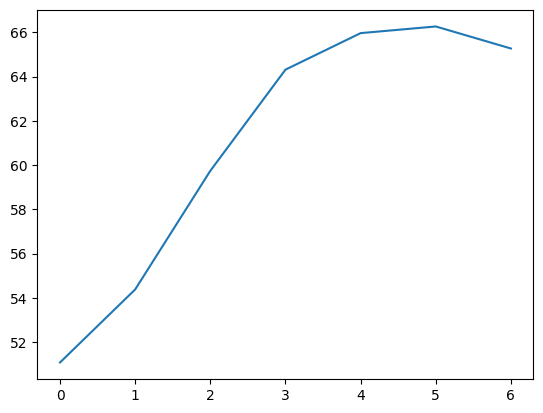

In [1015]:
plt.plot(vector)

In [761]:
a=df_dry.VALUES.values[0][0]

In [577]:
 data[(data.geo==nuts)&(data.year.isin(window))]

year    geo sector  area  employment  gdp  gross value added  \
19434  2015  SE231      A   NaN         5.0  NaN             280.86   
19435  2016  SE231      A   NaN         5.0  NaN             292.11   
19436  2017  SE231      A   NaN         5.0  NaN             318.00   
19437  2018  SE231      A   NaN         5.0  NaN             298.10   

       population  norm_GVA  national_GVA  diff_national_GVA  diff_GVA  \
19434         NaN    56.172     61.706688           0.062113 -0.046002   
19435         NaN    58.422     60.660812          -0.017241  0.038513   
19436         NaN    63.600     65.411471           0.072627  0.081415   
19437         NaN    59.620     64.239662          -0.018241 -0.066756   

       local_ppt_dev_GVA NUTS_ID  is_dry  
19434          -0.108114   SE231     1.0  
19435           0.055754   SE231     0.0  
19436           0.008788   SE231     0.0  
19437          -0.048515   SE231     6.0

In [ ]:
### 

In [557]:
data.groupby('is_dry').mean('local_ppt_dev_GVA')

year  area  employment  gdp  gross value added  population  \
is_dry                                                                      
0.0     2009.583600   NaN    9.479992  NaN         169.987857         NaN   
1.0     2010.464488   NaN    9.542187  NaN         151.353459         NaN   
2.0     2010.678571   NaN   11.263944  NaN         141.594371         NaN   
3.0     2015.600000   NaN    5.702708  NaN         134.537448         NaN   
4.0     2017.648352   NaN    3.010000  NaN         146.144835         NaN   
5.0     2018.000000   NaN    2.180345  NaN          94.329425         NaN   
6.0     2018.000000   NaN    2.004250  NaN          77.469500         NaN   
7.0     2018.000000   NaN    1.821667  NaN          74.147833         NaN   
8.0     2018.000000   NaN    1.988852  NaN          78.896230         NaN   
9.0     2018.000000   NaN    1.637727  NaN          58.012273         NaN   
10.0    2018.000000   NaN    0.250000  NaN           6.660000         NaN   

         norm_GVA  national_GVA  diff_national_GVA  diff_GVA  \
is_dry                                                         
0.0     29.665612     29.344734           0.015560  0.002599   
1.0     27.819342     27.872451           0.036584  0.019840   
2.0     28.678680     27.934253           0.042091  0.032625   
3.0     44.209879     41.381861          -0.028250 -0.009031   
4.0     42.261818     43.987184          -0.102181 -0.075112   
5.0     44.389029     42.362999          -0.110794 -0.085654   
6.0     38.133249     38.896756          -0.134005 -0.105078   
7.0     36.557697     39.325287          -0.138750 -0.250325   
8.0     41.866741     38.992769          -0.139911 -0.241634   
9.0     35.576576     39.215147          -0.142496 -0.229784   
10.0    26.640000     39.215147          -0.142496 -0.186764   

        local_ppt_dev_GVA  
is_dry                     
0.0             -0.013825  
1.0             -0.015732  
2.0             -0.008832  
3.0              0.027027  
4.0              0.024852  
5.0              0.020313  
6.0              0.028927  
7.0             -0.111575  
8.0             -0.101724  
9.0             -0.087289  
10.0            -0.044268

In [1126]:
data.to_csv('s3://ecb-hackathon-data-group02-x19s00/our_data/economic_climate_data.csv',sep=';')#.iloc[:,-6:].corr()

In [ ]:
hi.columns = ['date','year','NUTS_ID','HI']

hi.date=pd.to_datetime(hi.date)
hi['month']=hi.date.dt.month
hi = hi.sort_values(['NUTS_ID','date'])

hi['delta']=hi.sort_values(['NUTS_ID','date']).date.diff().diff().diff().diff().diff().diff().astype(str)

hi = hi[hi.month.isin([4,5,6,7,8,9])]

list_waves = hi.loc[hi.delta=='0 days',['year','NUTS_ID']].drop_duplicates()#.iloc[0:10]

In [1064]:
data.sample(5)

year    geo sector  area  employment     gdp      GVA  population  \
252701  2017  SI035    O-U   NaN        3.72     NaN    98.26         NaN   
124680  2011  FR106      C   NaN       32.49     NaN  2874.56         NaN   
23955   2018  BG423    M_N   NaN        2.52     NaN    18.82         NaN   
112452  2006  ES421      C   NaN       21.30     NaN   797.00         NaN   
60807   2011  DE927    NaN   NaN         NaN  2980.9      NaN      121.37   

         norm_GVA  national_GVA  diff_national_GVA   diff_GVA  \
252701  26.413978     86.948859           0.000000  -0.060644   
124680  88.475223    106.487850           0.000000  -0.153207   
23955    7.468254     42.140090           0.000000 -32.057961   
112452  37.417840           NaN                NaN  -0.041251   
60807         NaN     55.836385           0.044571        NaN   

        local_ppt_dev_GVA       SMA      TMAX     SPI_x     SPI_y       LFI  \
252701          -0.060644 -0.001417 -0.001417 -0.001417 -0.001417 -0.001417   
124680          -0.153207 -0.391958 -0.391958 -0.391958 -0.391958 -0.391958   
23955          -32.057961  0.016667  0.016667  0.530750  0.530750  0.016667   
112452                NaN  0.110333  0.110333  0.110333  0.110333  0.110333   
60807                 NaN -0.454375 -0.454375 -0.454375 -0.454375 -0.454375   

            APAR  
252701 -0.001417  
124680 -0.391958  
23955   0.016667  
112452  0.110333  
60807  -0.454375

In [435]:
data[data.MEDIAN<-3.5].local_ppt_dev_GVA.mean()

0.020991598307536823

In [436]:
data[data.MEDIAN>-3.5].local_ppt_dev_GVA.mean()

-0.01468292514423821

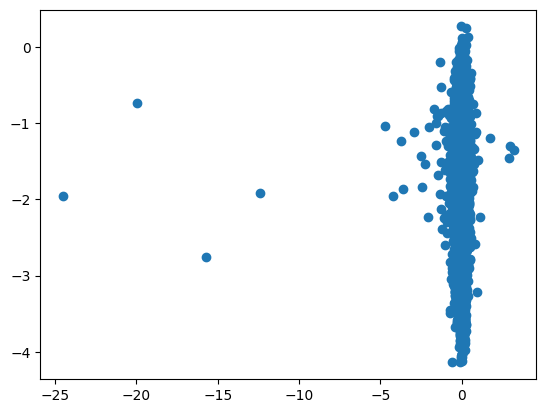

In [429]:
plt.plot(data.local_ppt_dev_GVA,data.MEDIAN,'o')

In [477]:
import geopandas as gpd

nuts3 = gpd.read_file('s3://ecb-hackathon-data-group02-x19s00/economic_data/regional_boundaries/NUTS_RG_20M_2021_3035.shp')

nuts3 = nuts3[nuts3.LEVL_CODE==3] 

nuts3['centroid']=nuts3.centroid.to_crs(epsg=4326)#.iloc[1].x

list_near = []
for index, row in tqdm.tqdm(nuts3.iterrows()):
    list_NUTS3 = []
    x1= row.centroid.x
    y1= row.centroid.y
    for index2, row2 in nuts3.iterrows():
        x2 = row2.centroid.x
        y2 = row2.centroid.y
        if geopy.distance.geodesic((x1,y1),(x2,y2)).km<200:
            list_NUTS3.append(row2.NUTS_ID)
    list_near.append(list_NUTS3)

nuts3['NEAR_NUTS']=list_near

nuts3['LAT'] = nuts3.centroid.to_crs(epsg=4326).apply(lambda x:x.x)
nuts3['LON'] = nuts3.centroid.to_crs(epsg=4326).apply(lambda x:x.y)

In [1124]:
nuts3.to_csv('s3://ecb-hackathon-data-group02-x19s00/our_data/nuts3_enriched.csv',sep=';')

In [513]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

geopy.distance.geodesic((nuts3.centroid.to_crs(epsg=4326).iloc[1].x,nuts3.centroid.to_crs(epsg=4326).iloc[1].y), 
                        (nuts3.centroid.to_crs(epsg=4326).iloc[2].x,nuts3.centroid.to_crs(epsg=4326).iloc[2].y)).km

62.673698925013554

In [1136]:
data = data[['year','geo','sector','employment','GVA','norm_GVA','SMA','TMAX','SPI','LFI','APAR','HI']]

In [1142]:
data['sector'] = data.sector.fillna('0')
#isna().sum()/data.isna().count()

/tmp/ipykernel_27008/1541334009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sector'] = data.sector.fillna('0')


In [1144]:
data.isna().sum()/data.isna().count()

year          0.000000
geo           0.000000
sector        0.000000
employment    0.103882
GVA           0.107687
norm_GVA      0.135238
SMA           0.025086
TMAX          0.108731
SPI           0.015288
LFI           0.158322
APAR          0.596803
HI            0.263867
dtype: float64

In [1149]:
import numpy as np
from sklearn.impute import KNNImputer
nan = np.nan
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(data.iloc[:100000,3:])

KeyboardInterrupt: 

In [ ]:
data.isna().sum()/data.isna().count()

In [1147]:
data

year    geo sector  employment      GVA   norm_GVA       SMA  \
0       2002  AT111      0         NaN      NaN        NaN -1.783667   
1       2002  AT111      A        1.60    37.00  23.125000 -1.783667   
2       2002  AT111    B-E        2.50   117.00  46.800000 -1.783667   
3       2002  AT111      C        2.20    92.00  41.818182 -1.783667   
4       2002  AT111      F        1.70    84.00  49.411765 -1.783667   
...      ...    ...    ...         ...      ...        ...       ...   
256795  2018  SK042    M_N       24.29   937.74  38.606011 -0.442250   
256796  2018  SK042    O-Q       72.62  1265.46  17.425778 -0.442250   
256797  2018  SK042    O-U       82.08  1511.59  18.416058 -0.442250   
256798  2018  SK042    R-U        9.46   246.13  26.017970 -0.442250   
256799  2018  SK042  TOTAL      294.60  9588.14  32.546300 -0.442250   

            TMAX       SPI       LFI      APAR        HI  
0       14.16375 -0.984792       NaN       NaN  2.908418  
1       14.16375 -0.984792       NaN       NaN  2.908418  
2       14.16375 -0.984792       NaN       NaN  2.908418  
3       14.16375 -0.984792       NaN       NaN  2.908418  
4       14.16375 -0.984792       NaN       NaN  2.908418  
...          ...       ...       ...       ...       ...  
256795  14.03500  0.538292  0.487917  0.069455  1.743665  
256796  14.03500  0.538292  0.487917  0.069455  1.743665  
256797  14.03500  0.538292  0.487917  0.069455  1.743665  
256798  14.03500  0.538292  0.487917  0.069455  1.743665  
256799  14.03500  0.538292  0.487917  0.069455  1.743665  

[256800 rows x 12 columns]

In [ ]:
## box plot idea
seaborn.boxplot(sp1,x='year',y='MEDIAN')


In [139]:
sect='F'
extreme_LFI = data.loc[(data.groupby(['geo'])['MAX_LFI'].transform(max) == data['MAX_LFI'])&(data.sector==sect)].norm_GVA.values
extreme_SPI = data.loc[(data.groupby(['geo'])['MIN_SPI'].transform(max) == data['MIN_SPI'])&(data.sector==sect)].norm_GVA.values
extreme_TMAX = data.loc[(data.groupby(['geo'])['MAX_TMAX'].transform(max) == data['MAX_TMAX'])&(data.sector==sect)].norm_GVA.values
extreme_APAR = data.loc[(data.groupby(['geo'])['MIN_APAR'].transform(min) == data['MIN_APAR'])&(data.sector==sect)].norm_GVA.values
extreme_SMA = data.loc[(data.groupby(['geo'])['MIN_SMA'].transform(min) == data['MIN_SMA'])&(data.sector==sect)].norm_GVA.values
extreme_HI = data.loc[(data.groupby(['geo'])['MAX_HI'].transform(max) == data['MAX_HI'])&(data.sector==sect)].norm_GVA.values
control = data[data.sector==sect].sample(1148).norm_GVA.values

/tmp/ipykernel_9849/2054921605.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  extreme_LFI = data.loc[(data.groupby(['geo'])['MAX_LFI'].transform(max) == data['MAX_LFI'])&(data.sector==sect)].norm_GVA.values
/tmp/ipykernel_9849/2054921605.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  extreme_SPI = data.loc[(data.groupby(['geo'])['MIN_SPI'].transform(max) == data['MIN_SPI'])&(data.sector==sect)].norm_GVA.values
/tmp/ipykernel_9849/2054921605.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used 

In [146]:
# same as above but with GVA instead of norm gva
sect='A'
extreme_LFI = data.loc[(data.groupby(['geo'])['MAX_LFI'].transform(max) == data['MAX_LFI'])&(data.sector==sect)].GVA.values
extreme_SPI = data.loc[(data.groupby(['geo'])['MIN_SPI'].transform(max) == data['MIN_SPI'])&(data.sector==sect)].GVA.values
extreme_TMAX = data.loc[(data.groupby(['geo'])['MAX_TMAX'].transform(max) == data['MAX_TMAX'])&(data.sector==sect)].GVA.values
extreme_APAR = data.loc[(data.groupby(['geo'])['MIN_APAR'].transform(min) == data['MIN_APAR'])&(data.sector==sect)].GVA.values
extreme_SMA = data.loc[(data.groupby(['geo'])['MIN_SMA'].transform(min) == data['MIN_SMA'])&(data.sector==sect)].GVA.values
extreme_HI = data.loc[(data.groupby(['geo'])['MAX_HI'].transform(max) == data['MAX_HI'])&(data.sector==sect)].GVA.values
control = data[data.sector==sect].sample(1148).GVA.values

/tmp/ipykernel_9849/227549351.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  extreme_LFI = data.loc[(data.groupby(['geo'])['MAX_LFI'].transform(max) == data['MAX_LFI'])&(data.sector==sect)].GVA.values
/tmp/ipykernel_9849/227549351.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  extreme_SPI = data.loc[(data.groupby(['geo'])['MIN_SPI'].transform(max) == data['MIN_SPI'])&(data.sector==sect)].GVA.values
/tmp/ipykernel_9849/227549351.py:5: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To 

In [147]:
df_boxplot = pd.DataFrame({'EXTREME_VALUES':extreme_LFI,'VARIABLE':'LFI'})
df_boxplot = pd.concat([df_boxplot, pd.DataFrame({'EXTREME_VALUES':extreme_SPI,'VARIABLE':'SPI'})])
df_boxplot = pd.concat([df_boxplot, pd.DataFrame({'EXTREME_VALUES':extreme_APAR,'VARIABLE':'APAR'})])
df_boxplot = pd.concat([df_boxplot, pd.DataFrame({'EXTREME_VALUES':extreme_SMA,'VARIABLE':'SMA'})])
df_boxplot = pd.concat([df_boxplot, pd.DataFrame({'EXTREME_VALUES':extreme_HI,'VARIABLE':'HI'})])
df_boxplot = pd.concat([df_boxplot, pd.DataFrame({'EXTREME_VALUES':extreme_TMAX,'VARIABLE':'TMAX'})])
df_boxplot = pd.concat([df_boxplot, pd.DataFrame({'EXTREME_VALUES':control,'VARIABLE':'CONTROL'})])

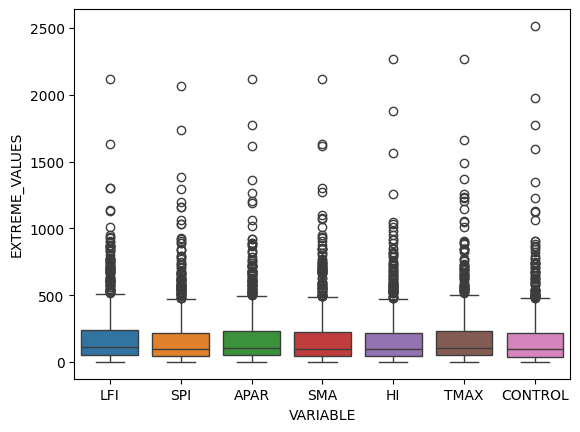

In [148]:
plot = seaborn.boxplot(df_boxplot.dropna(),x='VARIABLE',y='EXTREME_VALUES',hue='VARIABLE')
#plot.set_ylim(0, 300)

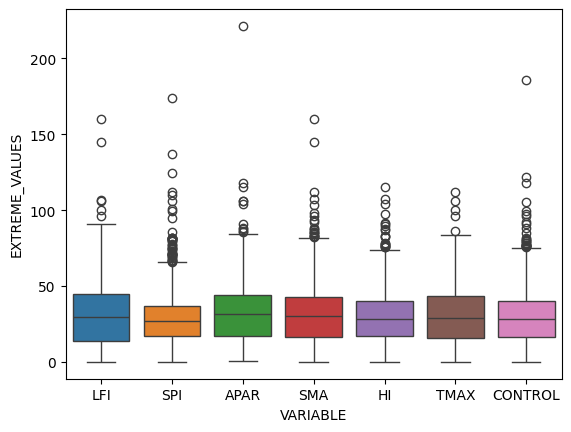

In [1205]:
plot = seaborn.boxplot(df_boxplot.dropna(),x='VARIABLE',y='EXTREME_VALUES',hue='VARIABLE')
#plot.set_ylim(0, 300)

In [1168]:
data_for_

year    geo sector  employment      GVA    norm_GVA       SMA  \
244621  2015  RO421    G-J       39.59   575.25   14.530184  0.017667   
91299   2017  DK021      L        2.00   958.51  479.255000 -0.016250   
36110   2005  DE216    B-E       11.01   591.66   53.738420 -0.279500   
128086  2002  FRC13      C       40.89  2343.05   57.301296 -0.223000   
128916  2003  FRC22      A        4.59   158.37   34.503268  0.129917   
...      ...    ...    ...         ...      ...         ...       ...   
93461   2016  EE001    O-Q       56.80  1589.20   27.978873  0.099000   
161048  2016  HU313    G-I       11.45   145.17   12.678603  0.556167   
109437  2011  ES120      C       49.90  3042.10   60.963928 -0.520833   
165091  2011  IE063      0         NaN      NaN         NaN  0.028333   
229066  2016  PT11D      J        0.24    14.09   58.708333  0.248500   

             TMAX       SPI       LFI      APAR        HI  
244621  17.233417 -0.167083  0.100417  0.312333  2.939499  
91299   11.865417 -0.089167       NaN -0.233778  1.168716  
36110   11.699583 -0.144500  0.383417       NaN       NaN  
128086  16.573167 -0.765000  0.141333       NaN  1.710616  
128916  15.786833 -0.226875  0.356583       NaN  2.605739  
...           ...       ...       ...       ...       ...  
93461    9.831833  0.105583  0.000000  0.039889  1.389895  
161048  15.430917  0.798583  0.043250  0.553167  0.379071  
109437  18.131000 -0.322583  0.163500       NaN       NaN  
165091  13.214167 -0.493167  0.000000       NaN  0.983452  
229066  19.198417  0.935083  0.000000  1.174083  1.903319  

[1148 rows x 12 columns]

MONTH    geo  year  LFI_WINTER  LFI_SUMMER
0      AL011  2001    0.000000    0.070000
1      AL011  2002    0.752667    0.000000
2      AL011  2003    0.000000    0.362000
3      AL011  2004    0.000000    0.000000
4      AL011  2005    0.102333    0.051000
...      ...   ...         ...         ...
23017  UKN0G  2014    0.119000    0.013333
23018  UKN0G  2015    0.018667    0.000000
23019  UKN0G  2016    0.000000    0.000000
23020  UKN0G  2017    0.269833    0.055833
23021  UKN0G  2018    0.000000    0.000000

[23022 rows x 4 columns]

In [1262]:
data

year    geo sector  employment      GVA   norm_GVA       SMA  \
0       2002  AT111      0         NaN      NaN        NaN -1.783667   
1       2002  AT111      A        1.60    37.00  23.125000 -1.783667   
2       2002  AT111    B-E        2.50   117.00  46.800000 -1.783667   
3       2002  AT111      C        2.20    92.00  41.818182 -1.783667   
4       2002  AT111      F        1.70    84.00  49.411765 -1.783667   
...      ...    ...    ...         ...      ...        ...       ...   
256795  2018  SK042    M_N       24.29   937.74  38.606011 -0.442250   
256796  2018  SK042    O-Q       72.62  1265.46  17.425778 -0.442250   
256797  2018  SK042    O-U       82.08  1511.59  18.416058 -0.442250   
256798  2018  SK042    R-U        9.46   246.13  26.017970 -0.442250   
256799  2018  SK042  TOTAL      294.60  9588.14  32.546300 -0.442250   

            TMAX       SPI       LFI      APAR        HI  
0       14.16375 -0.984792       NaN       NaN  2.908418  
1       14.16375 -0.984792       NaN       NaN  2.908418  
2       14.16375 -0.984792       NaN       NaN  2.908418  
3       14.16375 -0.984792       NaN       NaN  2.908418  
4       14.16375 -0.984792       NaN       NaN  2.908418  
...          ...       ...       ...       ...       ...  
256795  14.03500  0.538292  0.487917  0.069455  1.743665  
256796  14.03500  0.538292  0.487917  0.069455  1.743665  
256797  14.03500  0.538292  0.487917  0.069455  1.743665  
256798  14.03500  0.538292  0.487917  0.069455  1.743665  
256799  14.03500  0.538292  0.487917  0.069455  1.743665  

[256800 rows x 12 columns]

In [ ]:
## duration of the heatwave
hi = pd.read_csv('s3://ecb-hackathon-data-group02-x19s00/climate_data/heat_intensity/intensity_2001-2022.csv')

hi.columns = ['date','year','NUTS_ID','HI']

hi.date=pd.to_datetime(hi.date)
hi['month']=hi.date.dt.month
hi = hi.sort_values(['NUTS_ID','date'])

hi['delta']=hi.sort_values(['NUTS_ID','date']).date.diff().diff().diff().diff().diff().diff().astype(str)

hi = hi[hi.month.isin([4,5,6,7,8,9])]

list_waves = hi.loc[hi.delta=='0 days',['year','NUTS_ID']].drop_duplicates()#.iloc[0:10]

In [1266]:
# count extreme spi per region
spi=pd.read_csv('s3://ecb-hackathon-da\
ta-group02-x19s00/climate_data/spi/spa01_NUTS3_MEDIAN_2002.csv')

spi.columns = ['NUTS_ID','TIMESTAMP','MEDIAN']

spi[spi.MEDIAN<-3].groupby(spi.NUTS_ID.str[:2]).count().sort_values('MEDIAN',ascending=False)

NUTS_ID  TIMESTAMP  MEDIAN
NUTS_ID                            
LT             2          2       2
EE             1          1       1
LV             1          1       1
SE             1          1       1